<a href="https://colab.research.google.com/github/raj963/Face-detection/blob/master/Emotion_Detection_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Emotion Detection with Deep Learning

### Will experiment with the cv2 library
### and the model built by Priya Dwivedi from her [great medium post](https://towardsdatascience.com/face-detection-recognition-and-emotion-detection-in-8-lines-of-code-b2ce32d4d5de)

### Mount GDrive for assets

Must be run every time the notebook is initialized

In [0]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [0]:
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Do our imports

#### There is also a patch for google colab to use cv2_imshow correctly in a notebook

In [0]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# import face_recognition
import keras
from keras.models import load_model
import cv2
import warnings
import time
from google.colab.patches import cv2_imshow # fixes incompatibility of cv2 and jupyter
warnings.filterwarnings('ignore')
face_path = "/content/"
model_path = "/content/Colab Notebooks/models/"
gdrive_path = "/content/Colab Notebooks/"


In [0]:
!wget https://mlpractitioner.com/wp-content/uploads/trump_16_faces2.zip

--2020-04-25 12:48:21--  https://mlpractitioner.com/wp-content/uploads/trump_16_faces2.zip
Resolving mlpractitioner.com (mlpractitioner.com)... 35.222.138.69
Connecting to mlpractitioner.com (mlpractitioner.com)|35.222.138.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 912910 (892K) [application/zip]
Saving to: ‘trump_16_faces2.zip’

trump_16_faces2.zip 100%[===================>] 891.51K   900KB/s    in 1.0s    

2020-04-25 12:48:24 (900 KB/s) - ‘trump_16_faces2.zip’ saved [912910/912910]



In [0]:
import tarfile
import numpy as np 

tar = tarfile.open("/content/74qZO03LmoMZs40XfnY8%2Fversions%2FWRuHkmXxQAJkDTZ26L0A%2Ffiles%2Ffer2013.tar.gz", "r:gz")
for member in tar.getmembers():
     f = tar.extractfile(member)
     if f:
         content = f.read()
         Data = np.loadtxt(content)

ReadError: ignored

In [0]:
import lzma
with lzma.open("/content/fer2013.tar.gz") as f, open('extracted', 'wb') as fout:
    file_content = f.read()
    fout.write(file_content)

LZMAError: ignored

In [0]:
# We had a bunch of images saved on gdrive as a zip so we needed to unzip them locally on our colab instance
!unzip /content/trump_16_faces2.zip

Archive:  /content/trump_16_faces2.zip
  inflating: trump_anger1.png        
   creating: __MACOSX/
  inflating: __MACOSX/._trump_anger1.png  
  inflating: trump_anger2.png        
  inflating: __MACOSX/._trump_anger2.png  
  inflating: trump_anger3.png        
  inflating: __MACOSX/._trump_anger3.png  
  inflating: trump_anger4.png        
  inflating: __MACOSX/._trump_anger4.png  
  inflating: trump_disgust2.png      
  inflating: __MACOSX/._trump_disgust2.png  
  inflating: trump_fear1.png         
  inflating: __MACOSX/._trump_fear1.png  
  inflating: trump_fear2.png         
  inflating: __MACOSX/._trump_fear2.png  
  inflating: trump_fear3.png         
  inflating: __MACOSX/._trump_fear3.png  
  inflating: trump_fear4.png         
  inflating: __MACOSX/._trump_fear4.png  
  inflating: trump_happy1.png        
  inflating: __MACOSX/._trump_happy1.png  
  inflating: trump_happy2.png        
  inflating: __MACOSX/._trump_happy2.png  
  inflating: trump_neutral1.png      
  inflating

In [0]:
# This is where the emotion equates to a predicted class value
emotion_dict= {'Angry': 0, 'Sad': 5, 'Neutral': 4, 'Disgust': 1, 'Surprise': 6, 'Fear': 2, 'Happy': 3}

In [0]:
!wget https://github.com/priya-dwivedi/face_and_emotion_detection/raw/master/emotion_detector_models/model_v6_23.hdf5

--2020-04-25 12:51:49--  https://github.com/priya-dwivedi/face_and_emotion_detection/raw/master/emotion_detector_models/model_v6_23.hdf5
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/priya-dwivedi/face_and_emotion_detection/master/emotion_detector_models/model_v6_23.hdf5 [following]
--2020-04-25 12:51:50--  https://raw.githubusercontent.com/priya-dwivedi/face_and_emotion_detection/master/emotion_detector_models/model_v6_23.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2955168 (2.8M) [application/octet-stream]
Saving to: ‘model_v6_23.hdf5’

model_v6_23.hdf5    100%[===================>]  

In [0]:
# Load in the face emotional model provided by Priya Dwivedi http://www.deeplearninganalytics.org/
# The model was trained on fer2013 labeled face emotion image data set
model = load_model(model_path+"model_v6_23.hdf5")

## Emotion Detection Function

Function to do the emotion detection in one cell

**Pass in the image**

**Resize image : This model prefers 48x48 pixel grayscale images**

In [0]:
# The image lists for experimentation

# img_list = ['39.jpg','happy.jpg','suprise-guy.jpg','125.jpg','140.jpg','16.jpg','142.jpg','4.jpg','disgust-man-2.jpeg','angry-man-1.jpg','1950s-sad-boy.jpg','fearful-woman-1.jpg']
# img_list_2 = ['happy.jpg','sad2.jpg','surprise.jpg','fear.jpg']
# img_list_3 = ['125.jpg','140.jpg','16.jpg','142.jpg','4.jpg']
# img_list_4 = ['trump-anger-1.png','trump-fear-1.png','trump-neutral1.png']
# img_list_all = img_list+img_list_2

In [0]:
# Trump Face List
trump_img_list = ['trump_anger1.png','trump_anger2.png','trump_anger3.png','trump_anger4.png',
                  'trump_disgust2.png','trump_fear1.png','trump_fear2.png','trump_fear3.png','trump_fear4.png',
                  'trump_happy1.png','trump_happy2.png','trump_neutral1.png','trump_sad1.png','trump_sad2.png',
                  'trump_surprise1.png','trump_surprise2.png']



In [0]:
# Timer
def start_timer():
    tic = time.time()
    return(tic)

def tell_me_how_long(tic):
    toc = time.time()
    return(toc-tic)
    

In [0]:
def emotion_detection(image):
  #resized_image = cv2.resize(image, None, (48,48),interpolation=cv2.INTER_AREA)
  resized_image = cv2.resize(image, (48,48),interpolation=cv2.INTER_AREA)
  #cv2_imshow(resized_image)
# Reshape for 4D convolution input to model
  reshaped_resized_image = np.reshape(resized_image,[1,48,48,1])
# Do the prediction based on the emotional model
  current_time = start_timer()
  predicted_class = np.argmax(model.predict(reshaped_resized_image))
  elapsed_time = tell_me_how_long(current_time)
  print ('Elapsed Model Run Time : {:0.3f} seconds'.format(elapsed_time))
# Get the emotion string from the dictionary with predicted_class as index
  label_map = dict((v,k) for k,v in emotion_dict.items()) 
  predicted_label = label_map[predicted_class]
  #print('predicted class = ',predicted_class)
# Return the emotion string
  return(predicted_label,elapsed_time)

In [0]:
# Loop through the image list
# Build a list of images that can be iterated for plotting as an array
# Build a list of emotions that go along with the list
# Could use a multi-index df - 

In [0]:
list_of_images = []

# text label setup for cv2.put_Text()
color = (255,255,255)
thickness = 1
font_Scale = .7

MONTAGE_FILENAME = 'emotion_montage.jpg'

# Time this whole loop


list_of_times = []

for i in trump_img_list:
    cur_image = i
    color_image = cv2.imread(cur_image)
    bw_image = cv2.imread(cur_image,cv2.IMREAD_GRAYSCALE)
    # Call emotion_detection
    # Time it
    #current_time = start_timer()
    emotion, elapsed_time = emotion_detection(bw_image)
    
    #elapsed_time = tell_me_how_long(current_time)
    list_of_times.append(elapsed_time)
    
    #print ('Elapsed Model Run Time : {:0.3f} seconds'.format(elapsed_time))
    
    # After getting the emotions, resize the original color image to present in a montage later
    color_imager = cv2.resize(color_image, (96,96),interpolation=cv2.INTER_AREA)
    # use CV2 to put the current emotion text over the images (the emotion strings)
    cv2.putText(color_imager, emotion, (2, 20), cv2.FONT_HERSHEY_SIMPLEX, font_Scale, 
                  color, thickness,cv2.LINE_AA)
    # Build the image list
    list_of_images.append(color_imager)

print ('\n Average Model Run Time : {:0.3f} seconds'.format(sum(list_of_times)/len(list_of_times)))


# How long did this take?

Elapsed Model Run Time : 6.713 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.001 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.002 seconds
Elapsed Model Run Time : 0.001 seconds

 Average Model Run Time : 0.421 seconds


In [0]:
import ipywidgets as widgets
from IPython.display import display
import pylab
image_widget = widgets.Image(format='jpeg')

In [0]:
def convt_color(image):
    return(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [0]:
cvt_images = []

for i in range(0,len(list_of_images)):
    cvt_images.append(convt_color(list_of_images[i]))

In [0]:
mont_width = 4
mont_depth = 4
list_of_positions = []
for i in range(mont_width):
    for j in range(mont_depth):
        list_of_positions.append(tuple((i,j)))

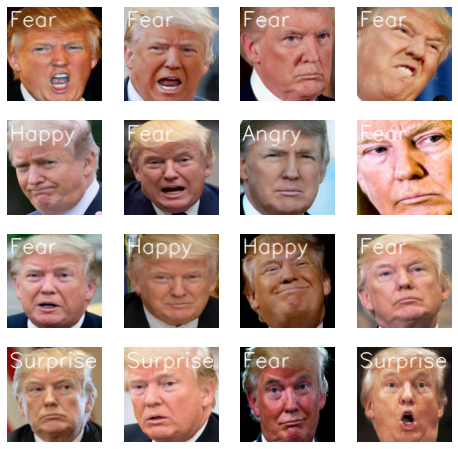

In [0]:
f, axarr = plt.subplots(mont_width,mont_depth, figsize=(8,8))
image_idx = 0

for i in range(len(list_of_positions)):
    axarr[list_of_positions[i]].axis('off')
    axarr[list_of_positions[i]].imshow(cvt_images[image_idx])
    image_idx += 1